In [1]:
!date

Fri Oct 30 17:01:59 PDT 2020


# Splitting clusters on isoforms

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import glob
import sys
def nd(arr):
    return np.asarray(arr).reshape(-1)

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [4]:
import ast

In [88]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [89]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to genes with more than one isoform

In [90]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [91]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 194 ms, sys: 164 µs, total: 194 ms
Wall time: 193 ms


In [92]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [93]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 6160 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 6160 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'high

In [94]:
isoform = isoform[isoform.obs.sort_values(["cluster_label", "cell_id"]).index]
gene = gene[gene.obs.sort_values(["cluster_label", "cell_id"]).index]

In [95]:
False in (gene.obs.cluster_label == isoform.obs.cluster_label)

False

In [96]:
isoform.obs

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,cell_id,subclass_id,class_id,cell_counts,leiden,louvain
112,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,LS-15501_S47_E1-50,0,3,985306.8750,7,7
1073,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-D9D87_S28_E1-50,0,3,982938.0625,7,7
4464,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-DD449_S01_E1-50,0,3,999301.3125,14,4
4991,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-GE65I_S103_E1-50,0,3,990256.1875,7,7
4992,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-GE65I_S104_E1-50,0,3,987743.6875,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...
6471,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S268_E1-50,17,0,997492.0625,12,12
6532,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S337_E1-50,17,0,998825.7500,12,12
6537,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S342_E1-50,17,0,998837.6875,5,12
6545,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S350_E1-50,17,0,998223.1250,12,12


# Cluster on the subclasses to see if there is an isoform that splits one 

In [97]:
from sklearn.cluster import KMeans

In [98]:
clusters = np.unique(isoform.obs.cluster_label.values)

In [99]:
%%time

# isoform level
check = []
files = []
for c in clusters:
    tmp = isoform[isoform.obs.eval(f"cluster_label== '{c}'")].copy()
    kmeans = KMeans(n_clusters=2, random_state=state).fit(tmp.X)
    tmp.obs["km"] = kmeans.labels_
    files.append(tmp)
    
    check += list(kmeans.labels_)

CPU times: user 22min 5s, sys: 1min 40s, total: 23min 46s
Wall time: 1min 29s


In [100]:
new_isoform = files[0].concatenate(*files[1:])

In [101]:
False in (new_isoform.obs.km.values == np.array(check))

False

# Plot new clusters

In [102]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [103]:
shape = np.round(np.sqrt(new_isoform.obs.cluster_label.nunique())).astype(int)
n_clusters = new_isoform.obs.cluster_label.nunique()

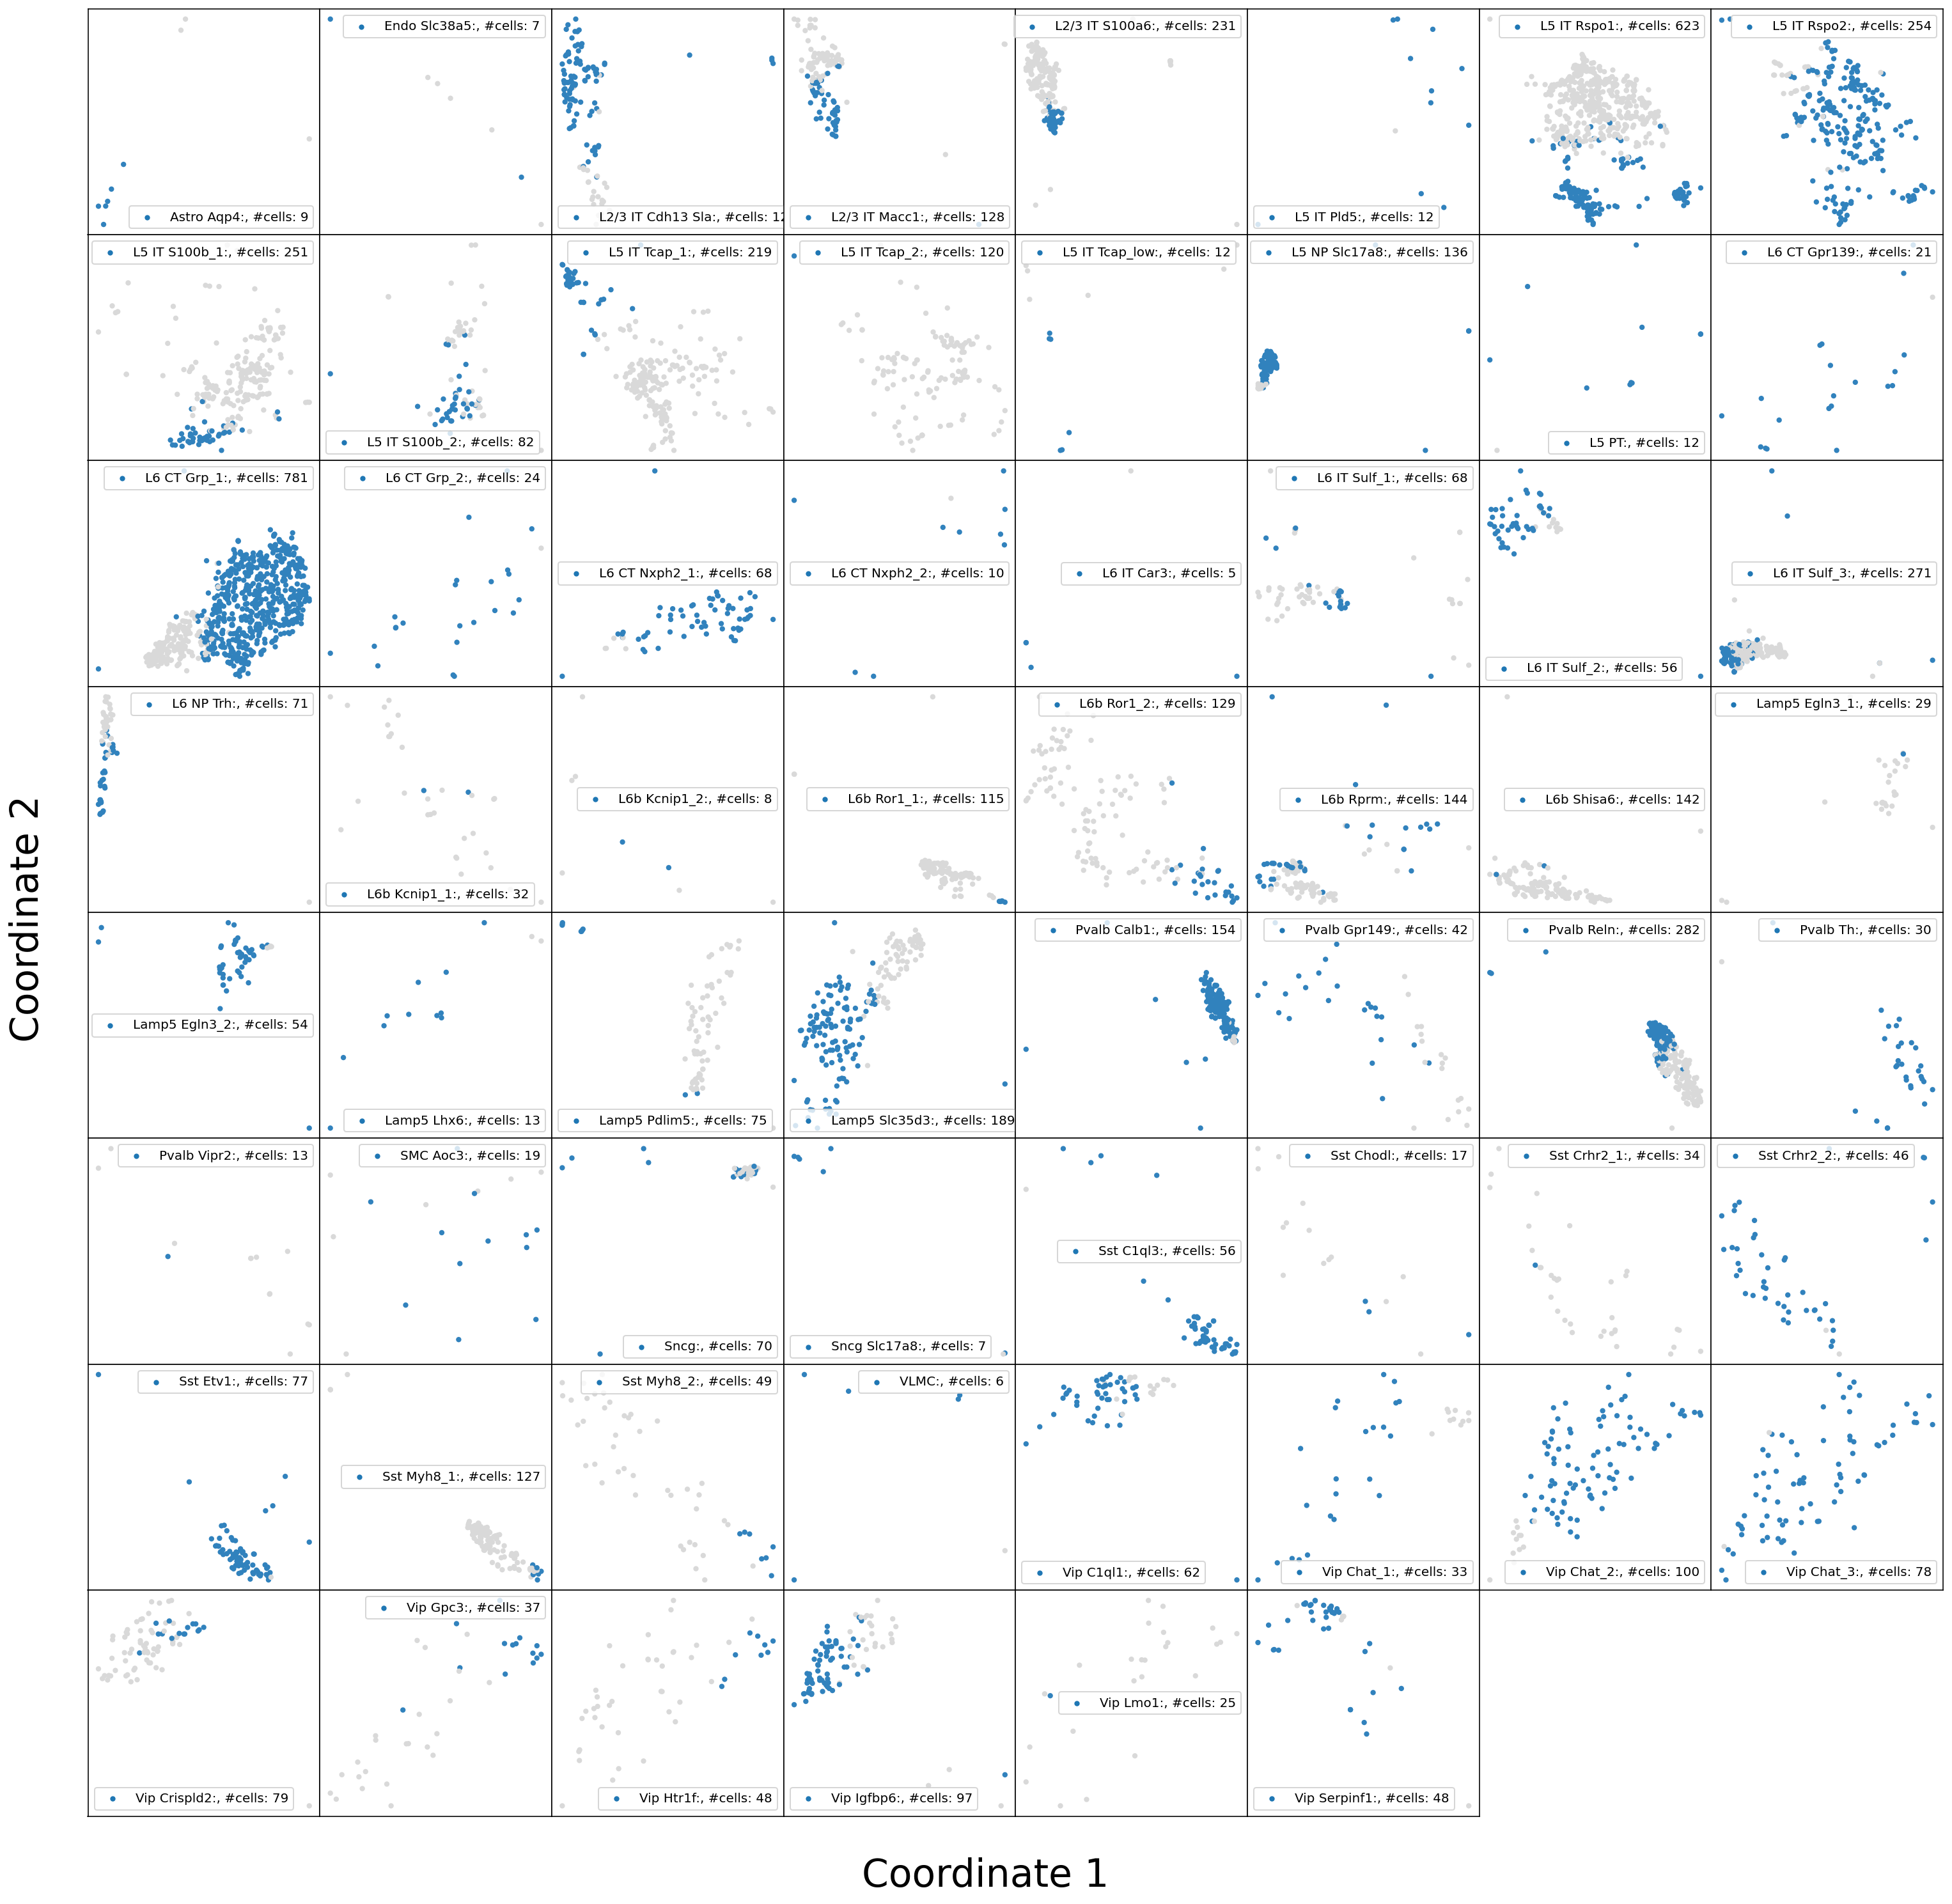

In [107]:
fig, ax = plt.subplots(figsize=(26,26), ncols=shape, nrows=shape)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, n_clusters)


for sidx, (ax, cluster) in enumerate(zip(axs, clusters)):
    tmp = new_isoform[new_isoform.obs.eval(f"cluster_label == '{cluster}'")]

    ax = axs[sidx]
    XX = tmp.obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    color = tmp.obs.km.astype(int)
    ax.scatter(x, y,s=10, c = color, cmap="tab20c", label=cluster+":, #cells: {:,}".format(x.shape[0]))# label=cluster+", #clusters {:,}".format(np.unique(color).shape[0]))
    ax.legend(fontsize=10)
    ax.set(**{
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
    })
    
fig.text(0.5, 0.1, 'Coordinate 1', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Coordinate 2', ha='center', va='center', rotation='vertical', fontsize=30)    

plt.savefig("../../figures/split_cluster_all.png",bbox_inches='tight', dpi=300)


fig.show()

In [105]:
gene.obs["km"] = new_isoform.obs.km.values

Trying to set attribute `.obs` of view, copying.


In [106]:
isoform = new_isoform.copy()

# determine the isoforms

In [108]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    color = kwd.get("color", "#D43F3A")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


# do for all clusters with a certain number of cells per cluster

In [109]:
%%time
n_cells = 109
fraction = 0.20

de_clusters = []
de_genes = []
de_isoforms = []
for cidx, c in enumerate(clusters):
    print(f"{cidx+1} of {len(clusters)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"cluster_label == '{c}'")].copy()
    tmp_gene    = gene[gene.obs.eval(f"cluster_label == '{c}'")].copy()

    if tmp_isoform.shape[0] >= n_cells: # cluster must have at least 109 cells
        if (tmp_isoform.obs.km.value_counts()/tmp_isoform.shape[0] > fraction).sum() == 2: # must have at least 20% of total cells in a clusters
                de_clusters.append(c)
                
                ####### Genes
                mat           = tmp_gene.layers["log1p"].todense()
                components    = tmp_gene.obs.cell_id.values
                features      = tmp_gene.var.gene_name.values
                assignments   = tmp_gene.obs.km.values

                # parameters
                unique        = np.unique(assignments)
                nan_cutoff    = 0.9 # of elements in cluster
                corr_method   = "bonferroni"
                
                p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
                p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

                s = stat

                markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

                # convert the 0 pvalues to the smallest possible float
                markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
                markers_gene["n_isoforms"] = markers_gene.name.map(gene.var.num_isoforms)
                de_genes.append(markers_gene)
                
                

                ######### Isoforms
                mat           = tmp_isoform.layers["log1p"].todense()
                components    = tmp_isoform.obs.cell_id.values
                features      = tmp_isoform.var.transcript_name.values
                assignments   = tmp_isoform.obs.km.values

                # parameters
                unique        = np.unique(assignments)
                nan_cutoff    = 0.9 # of elements in cluster
                corr_method   = "bonferroni"
                
                
                p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
                p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

                s = stat

                markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

                # convert the 0 pvalues to the smallest possible float
                markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
                de_isoforms.append(markers_isoform)

1 of 62: Astro Aqp4
2 of 62: Endo Slc38a5
3 of 62: L2/3 IT Cdh13 Sla


05-Nov-20 14:17:41 - 1 of 2 assignments: 0
05-Nov-20 14:17:41 - 2 of 2 assignments: 1
05-Nov-20 14:17:41 - 1 of 2 assignments: 0
05-Nov-20 14:17:41 - 2 of 2 assignments: 1
05-Nov-20 14:17:41 - 1 of 2 assignments: 0
05-Nov-20 14:17:41 - 2 of 2 assignments: 1


4 of 62: L2/3 IT Macc1


05-Nov-20 14:17:41 - 1 of 2 assignments: 0
05-Nov-20 14:17:41 - 2 of 2 assignments: 1


5 of 62: L2/3 IT S100a6


05-Nov-20 14:17:41 - 1 of 2 assignments: 0
05-Nov-20 14:17:42 - 2 of 2 assignments: 1
05-Nov-20 14:17:42 - 1 of 2 assignments: 0
05-Nov-20 14:17:42 - 2 of 2 assignments: 1


6 of 62: L5 IT Pld5
7 of 62: L5 IT Rspo1


05-Nov-20 14:17:42 - 1 of 2 assignments: 0
05-Nov-20 14:17:42 - 2 of 2 assignments: 1
05-Nov-20 14:17:43 - 1 of 2 assignments: 0
05-Nov-20 14:17:43 - 2 of 2 assignments: 1


8 of 62: L5 IT Rspo2
9 of 62: L5 IT S100b_1
10 of 62: L5 IT S100b_2
11 of 62: L5 IT Tcap_1


05-Nov-20 14:17:44 - 1 of 2 assignments: 0
05-Nov-20 14:17:44 - 2 of 2 assignments: 1
05-Nov-20 14:17:44 - 1 of 2 assignments: 0
05-Nov-20 14:17:44 - 2 of 2 assignments: 1


12 of 62: L5 IT Tcap_2
13 of 62: L5 IT Tcap_low
14 of 62: L5 NP Slc17a8


05-Nov-20 14:17:45 - 1 of 2 assignments: 0
05-Nov-20 14:17:45 - 2 of 2 assignments: 1
05-Nov-20 14:17:45 - 1 of 2 assignments: 0
05-Nov-20 14:17:45 - 2 of 2 assignments: 1


15 of 62: L5 PT
16 of 62: L6 CT Gpr139
17 of 62: L6 CT Grp_1


05-Nov-20 14:17:46 - 1 of 2 assignments: 0
05-Nov-20 14:17:46 - 2 of 2 assignments: 1
05-Nov-20 14:17:46 - 1 of 2 assignments: 0
05-Nov-20 14:17:47 - 2 of 2 assignments: 1


18 of 62: L6 CT Grp_2
19 of 62: L6 CT Nxph2_1
20 of 62: L6 CT Nxph2_2
21 of 62: L6 IT Car3
22 of 62: L6 IT Sulf_1
23 of 62: L6 IT Sulf_2
24 of 62: L6 IT Sulf_3


05-Nov-20 14:17:48 - 1 of 2 assignments: 0
05-Nov-20 14:17:48 - 2 of 2 assignments: 1
05-Nov-20 14:17:48 - 1 of 2 assignments: 0
05-Nov-20 14:17:48 - 2 of 2 assignments: 1


25 of 62: L6 NP Trh
26 of 62: L6b Kcnip1_1
27 of 62: L6b Kcnip1_2


05-Nov-20 14:17:48 - 1 of 2 assignments: 0
05-Nov-20 14:17:48 - 2 of 2 assignments: 1


28 of 62: L6b Ror1_1
29 of 62: L6b Ror1_2


05-Nov-20 14:17:48 - 1 of 2 assignments: 0
05-Nov-20 14:17:49 - 2 of 2 assignments: 1
05-Nov-20 14:17:49 - 1 of 2 assignments: 0
05-Nov-20 14:17:49 - 2 of 2 assignments: 1


30 of 62: L6b Rprm


05-Nov-20 14:17:49 - 1 of 2 assignments: 0
05-Nov-20 14:17:49 - 2 of 2 assignments: 1


31 of 62: L6b Shisa6
32 of 62: Lamp5 Egln3_1
33 of 62: Lamp5 Egln3_2
34 of 62: Lamp5 Lhx6
35 of 62: Lamp5 Pdlim5
36 of 62: Lamp5 Slc35d3


05-Nov-20 14:17:50 - 1 of 2 assignments: 0
05-Nov-20 14:17:50 - 2 of 2 assignments: 1
05-Nov-20 14:17:50 - 1 of 2 assignments: 0
05-Nov-20 14:17:50 - 2 of 2 assignments: 1


37 of 62: Pvalb Calb1
38 of 62: Pvalb Gpr149
39 of 62: Pvalb Reln


05-Nov-20 14:17:50 - 1 of 2 assignments: 0
05-Nov-20 14:17:50 - 2 of 2 assignments: 1
05-Nov-20 14:17:51 - 1 of 2 assignments: 0
05-Nov-20 14:17:51 - 2 of 2 assignments: 1


40 of 62: Pvalb Th
41 of 62: Pvalb Vipr2
42 of 62: SMC Aoc3
43 of 62: Sncg
44 of 62: Sncg Slc17a8
45 of 62: Sst C1ql3
46 of 62: Sst Chodl
47 of 62: Sst Crhr2_1
48 of 62: Sst Crhr2_2
49 of 62: Sst Etv1
50 of 62: Sst Myh8_1
51 of 62: Sst Myh8_2
52 of 62: VLMC
53 of 62: Vip C1ql1
54 of 62: Vip Chat_1
55 of 62: Vip Chat_2
56 of 62: Vip Chat_3
57 of 62: Vip Crispld2
58 of 62: Vip Gpc3
59 of 62: Vip Htr1f
60 of 62: Vip Igfbp6
61 of 62: Vip Lmo1
62 of 62: Vip Serpinf1
CPU times: user 11.4 s, sys: 974 ms, total: 12.3 s
Wall time: 12.3 s


# plotting isoforms and genes

In [110]:
specific_clusters = ['L6 CT Grp_1','L6 IT Sulf_3']

In [113]:
de_clusters = np.array(de_clusters)

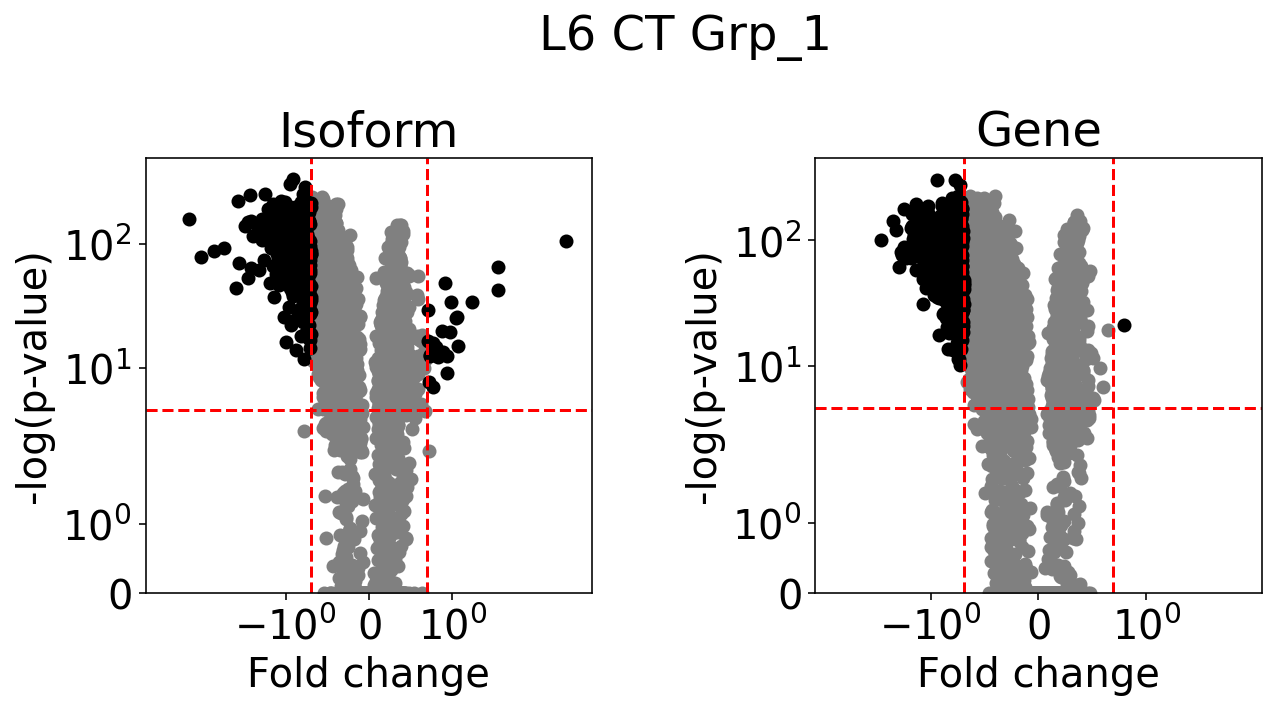

In [123]:
shape = len(specific_clusters)

fig, axs = plt.subplots(figsize=(5*2, 5*shape), ncols=2, nrows=shape)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle(specific_clusters[0])

for blah, (ax, cluster) in enumerate(zip(axs, specific_clusters)):
    idx = np.argwhere(cluster == de_clusters)[0][0]
    data = de_isoforms[idx].query("index == '0'")

    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[0])
    ax[0].set_title("Isoform")
    ax[1].set_title("Gene")

    data = de_genes[idx].query("index == '0'")
    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[1])
    
ax[0].remove()
ax[1].remove()

plt.savefig(f"../../figures/split_cluster_volcano_{'-'.join(specific_clusters[0])}.png",bbox_inches='tight', dpi=300)

fig.show()

In [42]:
alpha = 0.01

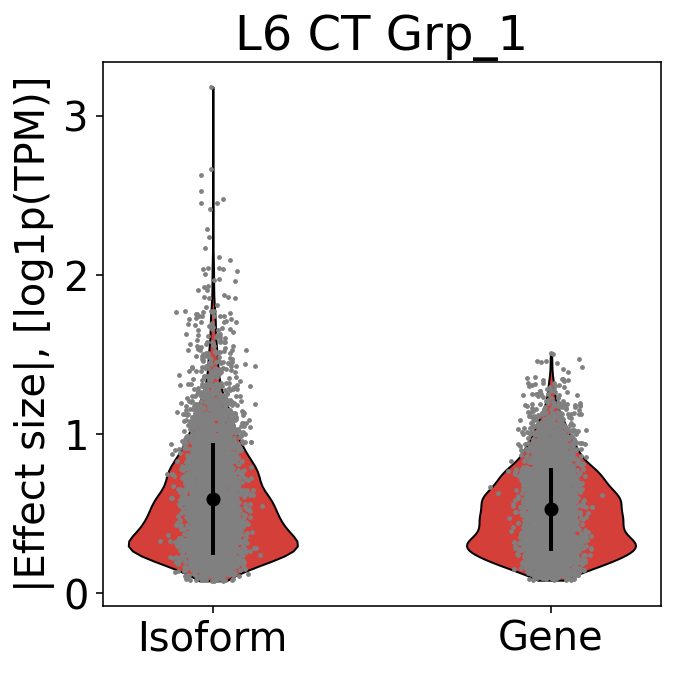

In [124]:
fig, axs = plt.subplots(figsize=(5,5), ncols=1)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

labels = ["Isoform", "Gene"]

ax = axs

cluster = specific_clusters[0]

idx = np.where(cluster == de_clusters)[0][0]

markers_isoform = de_isoforms[idx]
markers_gene = de_genes[idx]

lticks = np.arange(len(labels)) + 1
iso_mask = markers_isoform["p_corr"] < alpha
gen_mask = markers_gene["p_corr"] < alpha

data = [np.abs(markers_isoform["es"].values.astype(float))[iso_mask], np.abs(markers_gene["es"].values.astype(float))[gen_mask]]
plot.violinplot(data,  ax)

ax.set(**{
    "xticklabels": labels,
    "xticks": lticks,
    "ylabel": "|Effect size|, [log1p(TPM)]",
    "title": f"{cluster}"
 })

# ax = axs[1]

# cluster = specific_clusters[1]

# idx = np.where(cluster == de_clusters)[0][0]

# markers_isoform = de_isoforms[idx]
# markers_gene = de_genes[idx]

# lticks = np.arange(len(labels)) + 1
# iso_mask = markers_isoform["p_corr"] < alpha
# gen_mask = markers_gene["p_corr"] < alpha

# g = np.abs(markers_gene["es"].values.astype(float))[gen_mask]
# if len(g) == 0: g = [0];

# data = [np.abs(markers_isoform["es"].values.astype(float))[iso_mask], g]
# plot.violinplot(data,  ax)

# ax.set(**{
#     "xticklabels": labels,
#     "xticks": lticks,
#     "ylabel": "Effect size [log1p(TPM)]",
#     "title": f"{cluster}"
#  })

plt.savefig(f"../../figures/split_cluster_effect_size_{'-'.join(specific_clusters[0])}.png",bbox_inches='tight', dpi=300)


fig.show()

/home/sina/bin/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/sina/bin/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


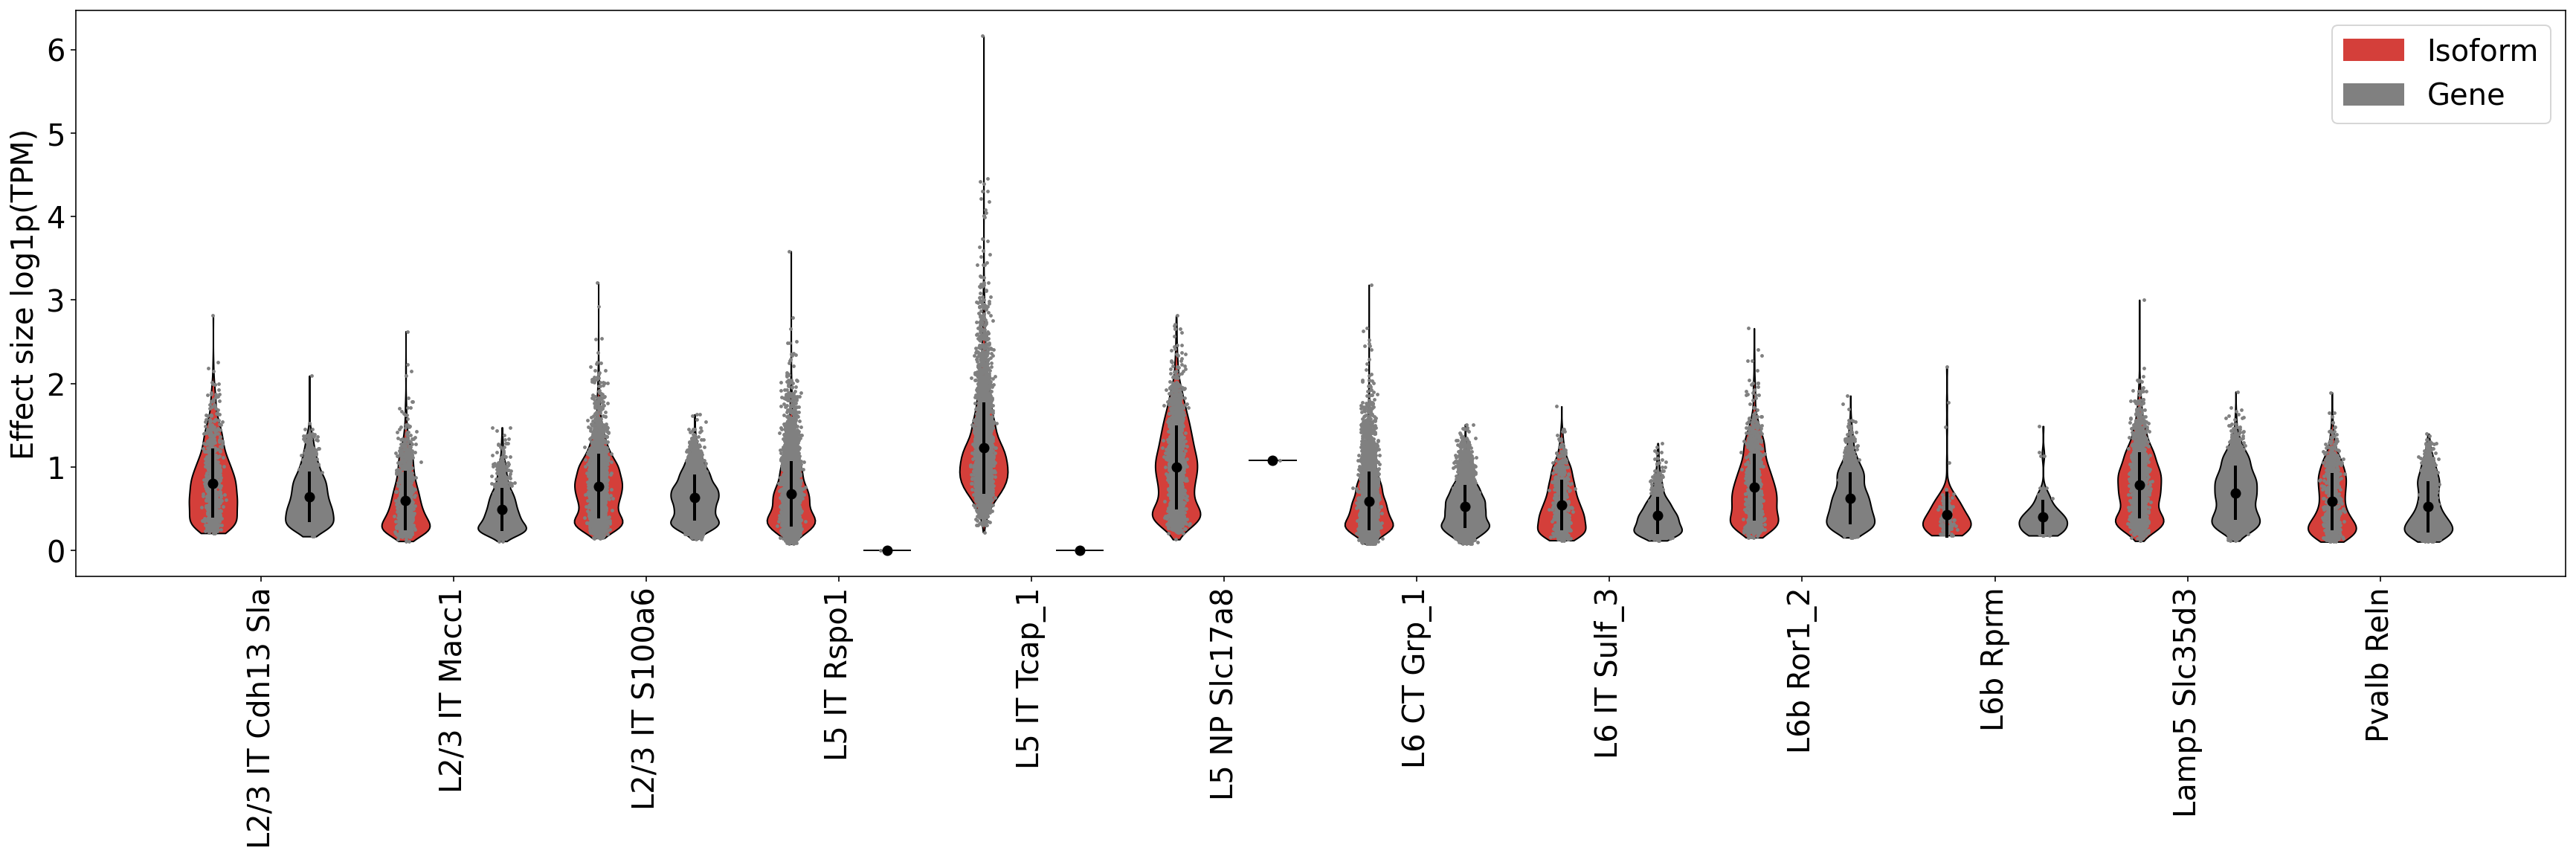

In [125]:
fig, ax = plt.subplots(figsize=(30,7))

labels = ["Isoform", "gene"]
lticks = np.arange(len(labels)) + 1

gees = []
iees = []


for didx, d in enumerate(de_clusters):
    iso_mask = de_isoforms[didx]["p_corr"] < alpha
    gen_mask = de_genes[didx]["p_corr"] < alpha

    i = np.abs(de_isoforms[didx]["es"].values.astype(float))[iso_mask]
    if len(i)==0: i=np.array([0]);
    iees.append(i)
    g = np.abs(de_genes[didx]["es"].values.astype(float))[gen_mask]
    if len(g)==0: g=np.array([0]);
    gees.append(g)


plot.violinplot(gees, ax, **{"xticks": np.arange(1, len(gees)*2, 2) + 1, "color": "grey"})
plot.violinplot(iees, ax, **{"xticks": np.arange(0, len(iees)*2, 2) + 1})

[stats.ttest_ind(i, j) for i, j in zip(iees, gees)]

ax.set(**{
    "xticks": np.arange(0.5, (len(iees))*2, 2)+1,
    "xticklabels": de_clusters,
    "ylabel": "Effect size log1p(TPM)",
})

ax.set_xticklabels(de_clusters, rotation = 90)
red_patch = mpatches.Patch(color="#D43F3A", label='Isoform')
grey_patch = mpatches.Patch(color="grey", label='Gene')
ax.legend(handles=[red_patch, grey_patch])


fig.show()

In [126]:
[stats.ttest_ind(i, j) for i, j in zip(iees, gees)]

[Ttest_indResult(statistic=8.826302584836785, pvalue=2.757036265452197e-18),
 Ttest_indResult(statistic=7.959280175097446, pvalue=2.8344959769886313e-15),
 Ttest_indResult(statistic=15.126084634533893, pvalue=9.165319913659432e-51),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=10.325889061133772, pvalue=7.321678253050681e-25),
 Ttest_indResult(statistic=8.42540580068756, pvalue=9.789597954520747e-17),
 Ttest_indResult(statistic=8.118921435885042, pvalue=7.866823413267806e-16),
 Ttest_indResult(statistic=0.8851056380762393, pvalue=0.3769112379847497),
 Ttest_indResult(statistic=7.558168740555954, pvalue=5.204054414014464e-14),
 Ttest_indResult(statistic=3.950726623148584, pvalue=8.113719953585414e-05)]

# Looking at the specific isoforms

In [127]:
cluster = specific_clusters[0]
idx = np.where(cluster == de_clusters)[0][0]

markers_isoform = de_isoforms[idx]
markers_gene = de_genes[idx]
print(cluster)

L6 CT Grp_1


In [128]:
markers_isoform.sort_values(["es","p_corr"])

,index,name,p_raw,p_corr,es
9358,0,Uba1-201_ENSMUST00000001989,1.97486e-73,7.76316e-70,-2.45422
20717,0,Rasal1-205_ENSMUST00000156722,3.44859e-38,1.35564e-34,-2.04364
53841,0,Rangap1-201_ENSMUST00000052374,2.7839e-42,1.09435e-38,-1.85437
38236,0,Slc22a17-210_ENSMUST00000228495,2.1441e-44,8.42846e-41,-1.74328
2184,0,Actr3-202_ENSMUST00000178474,1.45682e-23,5.72674e-20,-1.58973
...,...,...,...,...,...
73815,1,Gria2-203_ENSMUST00000192463,7.00068e-55,3.80487e-51,2.47919
100549,1,Ptk2b-203_ENSMUST00000111121,2.20644e-49,1.1992e-45,2.52557
74096,1,Syt11-205_ENSMUST00000183267,1.48263e-73,8.05811e-70,2.62721
89545,1,Slc17a7-202_ENSMUST00000209634,1.75984e-128,9.56475e-125,2.66592


In [129]:
gene.var[gene.var.gene_name.str.contains("App")]

,transcript_id,gene_id,gene_name,transcript_name,length,txn_list,num_isoforms,gene_counts,dispersion,pass_disp_filter,highly_variable,means,dispersions,dispersions_norm
Appl2_ENSMUSG00000020263,ENSMUST00000020500,ENSMUSG00000020263,Appl2_ENSMUSG00000020263,Appl2-201_ENSMUST00000020500,3020,"['ENSMUST00000020500', 'ENSMUST00000177187', '...",11,55.803417,0.074308,True,True,2.225524,4.343552,1.171203
Appl1_ENSMUSG00000040760,ENSMUST00000036570,ENSMUSG00000040760,Appl1_ENSMUSG00000040760,Appl1-201_ENSMUST00000036570,7642,"['ENSMUST00000036570', 'ENSMUST00000141599', '...",5,548.679443,0.060529,True,False,4.247553,3.506511,-0.407122
Appbp2os_ENSMUSG00000085628,ENSMUST00000206972,ENSMUSG00000085628,Appbp2os_ENSMUSG00000085628,Appbp2os-202_ENSMUST00000206972,447,"['ENSMUST00000206972', 'ENSMUST00000136454']",2,5.070610,0.015361,True,False,0.538054,2.665579,0.035462
App_ENSMUSG00000022892,ENSMUST00000227723,ENSMUSG00000022892,App_ENSMUSG00000022892,App-206_ENSMUST00000227723,8167,"['ENSMUST00000227723', 'ENSMUST00000227654', '...",10,3066.465088,0.180383,True,True,6.008129,4.831866,0.642426


In [130]:
i = "App-205_ENSMUST00000227654"
g = "App_ENSMUSG00000022892"

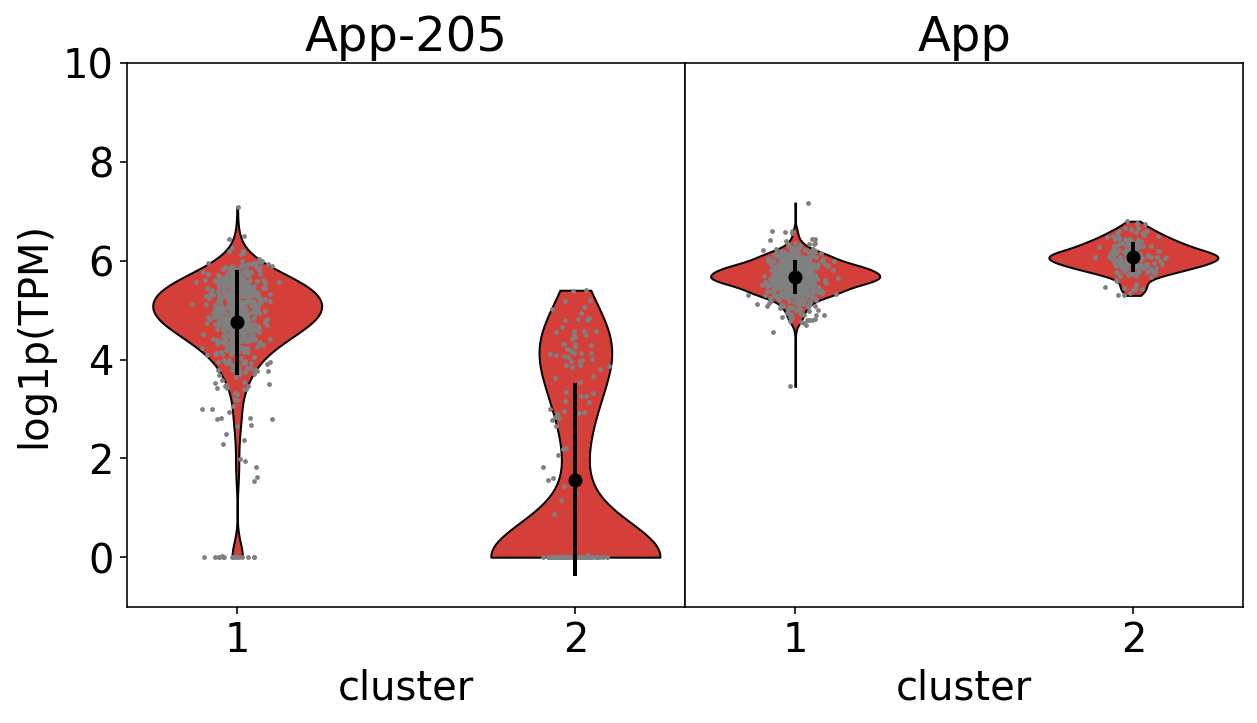

In [131]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

km = np.unique(isoform.obs.km.values)
cluster_mask = isoform.obs.eval(f"cluster_label=='{specific_clusters[0]}'").values.astype(bool)
iso_vector = nd(isoform.layers["log1p"][:, isoform.var.index.values == i].todense())[cluster_mask]
gene_vector = nd(gene.layers["log1p"][:, gene.var.index.values == g].todense())[cluster_mask]

lidx = np.arange(len(km)) + 1
labels = [f"{i}" for i in lidx]
kwd = {
    "xticks" : lidx,
    "xticklabels": labels,
    "xlabel":"cluster",
    "ylim": (-1, 10),
    "ylabel": "log1p(TPM)"
}

ax = axs[0]
mask = isoform.obs[cluster_mask].eval(f"km == '0'")

data = [iso_vector[mask], iso_vector[~mask]]

violinplot(data, ax)

ax.set_title(f"{i.split('_')[0]}")
ax.set(**kwd)



ax = axs[1]
mask = gene.obs[cluster_mask].eval(f"km == '0'")
data = [gene_vector[mask], gene_vector[~mask]]

violinplot(data,ax)

ax.set_title(f"{g.split('_')[0]}")
kwd["yticks"] = []
kwd["yticklabels"] = []
kwd["ylabel"] = ""
ax.set(**kwd)

plt.savefig(f"../../figures/split_cluster_{i.split('_')[0]}.png",bbox_inches='tight', dpi=300)


fig.show()

In [132]:
stats.ttest_ind(*data)

Ttest_indResult(statistic=-14.05018024720019, pvalue=3.92202813225978e-40)

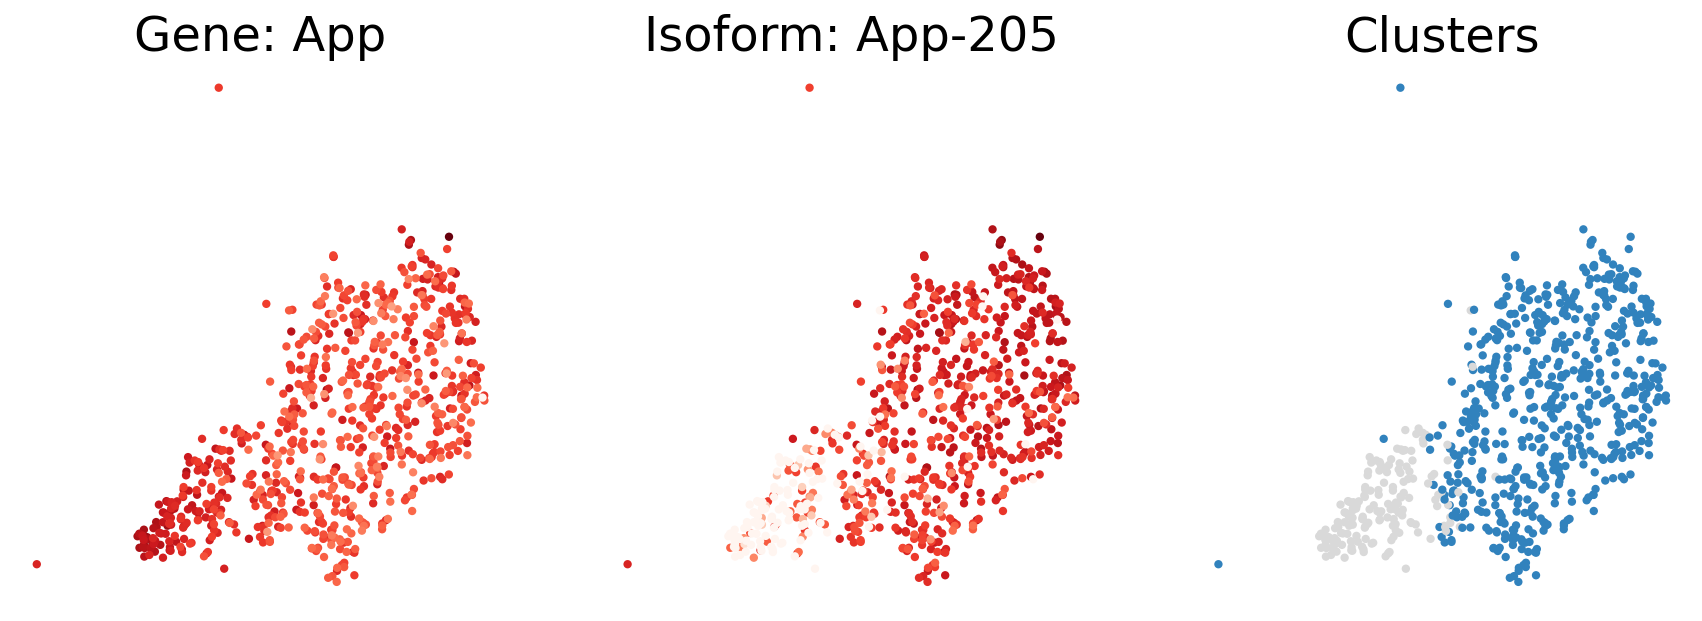

In [133]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

X = isoform.obsm["X_nca_tsne"][cluster_mask]

Yi = isoform.layers["log1p"][:, isoform.var.index.values == i][cluster_mask]
Yg = gene.layers["log1p"][:, gene.var.index.values == g][cluster_mask]

ax = axs[0] # gene

x = X[:,0]
y = X[:,1]
c = nd(Yg.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=10)
ax.set_axis_off()
ax.set_title(f"Gene: {g.split('_')[0]}")


ax = axs[1] # isoform

x = X[:,0]
y = X[:,1]
c = nd(Yi.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=10)
ax.set_axis_off()
ax.set_title(f"Isoform: {i.split('_')[0]}")

ax = axs[2] # clusters

x = X[:,0]
y = X[:,1]
c = isoform.obs[cluster_mask].km.values

ax.scatter(x,y, c=c, cmap="tab20c", s=10)
ax.set_axis_off()
ax.set_title("Clusters")

plt.savefig(f"../../figures/split_cluster_tsne_{i.split('_')[0]}.png",bbox_inches='tight', dpi=300)

fig.show()